In [1]:
import cv2
import matplotlib as plt
import helpers
import data_module
import numpy as np


/home/pabut/Third_Year/Bachelor/ISIQA/isiqa_release/isiqa_release/stitching_data/15/2.jpg
/home/pabut/Third_Year/Bachelor/ISIQA/isiqa_release/isiqa_release/stitching_data/15/3.jpg


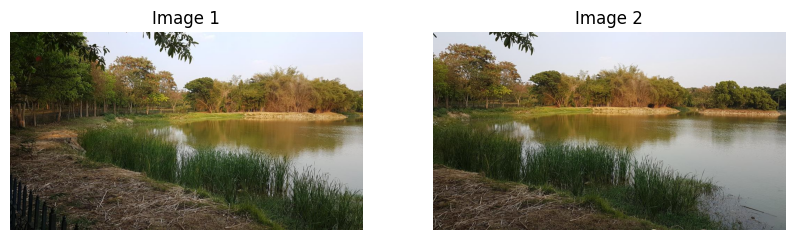

In [77]:
dm = data_module.ISIQADataModule('/home/pabut/Third_Year/Bachelor/ISIQA/isiqa_release/isiqa_release/stitching_data')

img1, img2 = dm.get_random_pair()


helpers.show_image_pair(img1, img2)

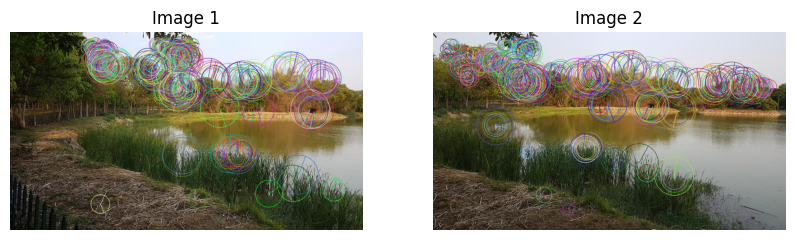

In [78]:
keypoints1, descriptors1 = cv2.ORB.create().detectAndCompute(img1, None)
keypoints2, descriptors2 = cv2.ORB.create().detectAndCompute(img2, None)

helpers.show_image_pair(cv2.drawKeypoints(img1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS), cv2.drawKeypoints(img2, keypoints2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

Good matches: 54
(54, 1, 2)
(504, 342) (653, 1427, 3)


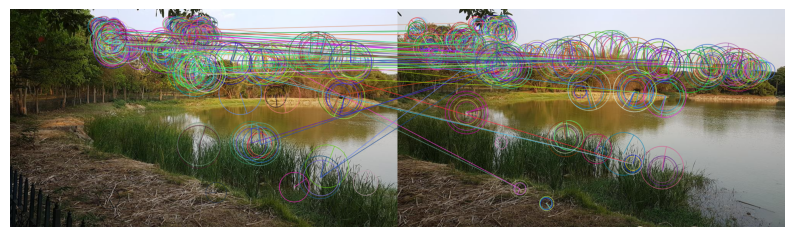

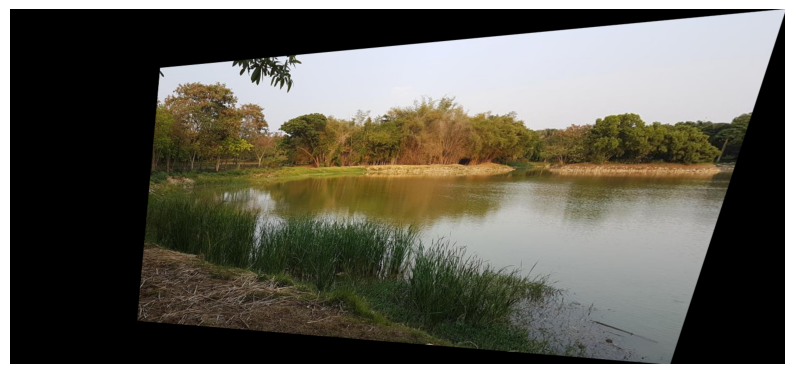

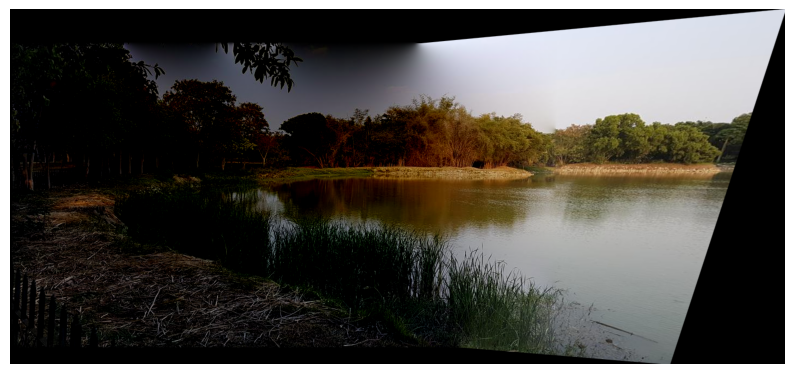

In [80]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors2, descriptors1, k=2)

good_matches = []

for m,n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

MIN_MATCH_COUNT = 4

print('Good matches:', len(good_matches))

if len(good_matches) > MIN_MATCH_COUNT:

    helpers.show_image(cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

    src_pts = np.float32([keypoints2[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints1[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    corners = np.array([[0, 0], [0, h2 - 1], [w2 - 1, h2 - 1], [w2 - 1, 0]], dtype='float32')
    warped_corners = cv2.perspectiveTransform(corners.reshape(-1, 1, 2), H)

    x_min = min(warped_corners[:, 0, 0])
    y_min = min(warped_corners[:, 0, 1])
    x_max = max(warped_corners[:, 0, 0])
    y_max = max(warped_corners[:, 0, 1])

    translation_matrix = np.array([[1, 0, 0], [0, 1, -y_min], [0, 0, 1]])
    adjusted_homography = translation_matrix @ H

    dst = cv2.warpPerspective(img2, adjusted_homography, (int(x_max - 0), max(int(y_max - y_min), img1.shape[0] - int(y_min))))

    helpers.show_image(dst)
    

    edgeCenter = (img1.shape[1] // 2, (img1.shape[0] // 2) - int(y_min))

    print(edgeCenter, dst.shape)


    mask = 255 * np.ones(img1.shape, img1.dtype)

    # padding = 0

    # mask = 255 * cv2.rectangle(mask, (0, padding), (img1.shape[1], img1.shape[0] - padding), (1, 1, 1), -1)

    # helpers.show_image(mask & img1)

    dst = cv2.seamlessClone(img1, dst, mask, edgeCenter, cv2.NORMAL_CLONE)

    # dst[:h1, :w1] = img1


    helpers.show_image(dst)

    # print(w1, h1)
else:
    print('No matches found')

